# 🏪 Store Sales - Time Series Forecasting
### Predict future unit sales for Corporación Favorita grocery stores in Ecuador

**Competition Goal**: Predict sales for thousands of product families using historical data, promotions, and external factors.

**Evaluation Metric**: RMSLE (Root Mean Squared Logarithmic Error)

---

## 📋 Strategy Overview
1. **Advanced Feature Engineering**: Time-series lags, rolling windows, external events
2. **Ensemble Modeling**: LightGBM + XGBoost + CatBoost
3. **Time-Based Validation**: Prevent data leakage with proper temporal splits

## 1️⃣ Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, Pool

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print('✅ Libraries imported successfully')

✅ Libraries imported successfully


## 2️⃣ Data Loading

In [2]:
# Load all datasets
train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv', parse_dates=['date'])
test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv', parse_dates=['date'])
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv', parse_dates=['date'])
holidays = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv', parse_dates=['date'])
sample_submission = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv')

print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')
print(f'Date range: {train.date.min()} to {train.date.max()}')
print(f'Test dates: {test.date.min()} to {test.date.max()}')

Train shape: (3000888, 6)
Test shape: (28512, 5)
Date range: 2013-01-01 00:00:00 to 2017-08-15 00:00:00
Test dates: 2017-08-16 00:00:00 to 2017-08-31 00:00:00


In [3]:
# Quick data exploration
print('\n📊 Training Data Sample:')
display(train.head())
print('\n📈 Sales Statistics:')
display(train['sales'].describe())
print(f'\n🏬 Number of stores: {train.store_nbr.nunique()}')
print(f'🛒 Number of product families: {train.family.nunique()}')


📊 Training Data Sample:


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0



📈 Sales Statistics:


count    3.000888e+06
mean     3.577757e+02
std      1.101998e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.100000e+01
75%      1.958473e+02
max      1.247170e+05
Name: sales, dtype: float64


🏬 Number of stores: 54
🛒 Number of product families: 33


## 3️⃣ Data Preprocessing

### 3.1 Oil Prices Processing

In [4]:
def process_oil(oil_df):
    """Fill missing oil prices using interpolation"""
    # Create complete date range
    full_dates = pd.date_range(start=oil_df['date'].min(), end=oil_df['date'].max())
    oil_complete = pd.DataFrame({'date': full_dates})
    oil_complete = oil_complete.merge(oil_df, on='date', how='left')
    
    # Interpolate missing values
    oil_complete['dcoilwtico'] = oil_complete['dcoilwtico'].interpolate(method='linear', limit_direction='both')
    
    # Add oil price changes
    oil_complete['oil_change'] = oil_complete['dcoilwtico'].diff()
    oil_complete['oil_change_7d'] = oil_complete['dcoilwtico'].diff(7)
    
    return oil_complete

oil_processed = process_oil(oil)
print(f'✅ Oil data processed: {len(oil_processed)} days')
print(f'Missing values: {oil_processed.isnull().sum().sum()}')

✅ Oil data processed: 1704 days
Missing values: 8


### 3.2 Holidays Processing

In [5]:
def process_holidays(holidays_df):
    """Process holidays - exclude transferred days, keep actual celebration dates"""
    # Remove transferred holidays (they act as normal days)
    holidays_clean = holidays_df[holidays_df['transferred'] == False].copy()
    
    # Create holiday features
    holidays_clean['is_national'] = (holidays_clean['locale'] == 'National').astype(int)
    holidays_clean['is_regional'] = (holidays_clean['locale'] == 'Regional').astype(int)
    holidays_clean['is_local'] = (holidays_clean['locale'] == 'Local').astype(int)
    
    # Aggregate by date (some dates have multiple holidays)
    holiday_agg = holidays_clean.groupby('date').agg({
        'is_national': 'max',
        'is_regional': 'max',
        'is_local': 'max'
    }).reset_index()
    
    return holiday_agg

holidays_processed = process_holidays(holidays)
print(f'✅ Holidays processed: {len(holidays_processed)} unique holiday dates')

✅ Holidays processed: 300 unique holiday dates


## 4️⃣ Feature Engineering

### 4.1 Merge Base Data

In [6]:
def merge_base_features(df, oil_df, stores_df, holidays_df):
    """Merge all base datasets"""
    # Merge oil prices
    df = df.merge(oil_df, on='date', how='left')
    
    # Merge store metadata
    df = df.merge(stores_df, on='store_nbr', how='left')
    
    # Merge holidays
    df = df.merge(holidays_df, on='date', how='left')
    df[['is_national', 'is_regional', 'is_local']] = df[['is_national', 'is_regional', 'is_local']].fillna(0)
    
    return df

# Merge for both train and test
train_merged = merge_base_features(train, oil_processed, stores, holidays_processed)
test_merged = merge_base_features(test, oil_processed, stores, holidays_processed)

print(f'✅ Base features merged')
print(f'Train shape: {train_merged.shape}')
print(f'Test shape: {test_merged.shape}')

✅ Base features merged
Train shape: (3000888, 16)
Test shape: (28512, 15)


### 4.2 Time-Based Features

In [7]:
def create_time_features(df):
    """Create comprehensive time-based features"""
    # Basic time features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['dayofyear'] = df['date'].dt.dayofyear
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    # Cyclical encoding for month and day of week
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    
    # Binary flags
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    df['is_quarter_start'] = df['date'].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df['date'].dt.is_quarter_end.astype(int)
    
    # Payday features (15th and last day of month)
    df['is_payday'] = ((df['day'] == 15) | df['is_month_end']).astype(int)
    df['days_to_payday'] = df.apply(lambda row: min(
        abs(row['day'] - 15),
        abs(row['day'] - pd.Timestamp(row['date']).days_in_month)
    ), axis=1)
    
    # Earthquake impact (April 16, 2016 - May 31, 2016)
    df['earthquake_impact'] = ((df['date'] >= '2016-04-16') & (df['date'] <= '2016-05-31')).astype(int)
    
    return df

train_merged = create_time_features(train_merged)
test_merged = create_time_features(test_merged)

print('✅ Time features created')

✅ Time features created


### 4.3 Lag & Rolling Window Features

**Important**: We use lags of at least 16 days to avoid data leakage (test window is 15 days)

In [8]:
def create_lag_features(df):
    """Create lag and rolling window features"""
    # Sort by store, family, and date
    df = df.sort_values(['store_nbr', 'family', 'date']).reset_index(drop=True)
    
    # Sales lags (16+ days to avoid leakage)
    lag_days = [16, 21, 30, 60, 90, 182, 365]
    for lag in lag_days:
        df[f'sales_lag_{lag}'] = df.groupby(['store_nbr', 'family'])['sales'].transform(
            lambda x: x.shift(lag)
        )
    
    # Rolling window statistics (shifted by 16 days)
    windows = [7, 14, 30, 90]
    for window in windows:
        # Rolling mean
        df[f'rolling_mean_{window}'] = df.groupby(['store_nbr', 'family'])['sales'].transform(
            lambda x: x.shift(16).rolling(window=window, min_periods=1).mean()
        )
        # Rolling std
        df[f'rolling_std_{window}'] = df.groupby(['store_nbr', 'family'])['sales'].transform(
            lambda x: x.shift(16).rolling(window=window, min_periods=1).std()
        )
    
    # Exponentially weighted moving average
    df['ewm_7'] = df.groupby(['store_nbr', 'family'])['sales'].transform(
        lambda x: x.shift(16).ewm(span=7, adjust=False).mean()
    )
    
    # Promotion lags
    df['promo_lag_16'] = df.groupby(['store_nbr', 'family'])['onpromotion'].transform(
        lambda x: x.shift(16)
    )
    
    return df

# Combine train and test for proper lag calculation
print('Creating lag features (this may take a few minutes)...')
full_data = pd.concat([train_merged, test_merged], axis=0, ignore_index=True)
full_data = create_lag_features(full_data)

# Split back
train_final = full_data[full_data['sales'].notna()].reset_index(drop=True)
test_final = full_data[full_data['sales'].isna()].reset_index(drop=True)

print(f'✅ Lag features created')
print(f'Train shape: {train_final.shape}')
print(f'Test shape: {test_final.shape}')

Creating lag features (this may take a few minutes)...
✅ Lag features created
Train shape: (3000888, 51)
Test shape: (28512, 51)


### 4.4 Encode Categorical Variables

In [9]:
# Categorical columns to encode
cat_cols = ['family', 'city', 'state', 'type', 'cluster']

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    # Combine train and test for consistent encoding
    combined = pd.concat([train_final[col], test_final[col]]).astype(str)
    le.fit(combined)
    
    train_final[col] = le.transform(train_final[col].astype(str))
    test_final[col] = le.transform(test_final[col].astype(str))
    label_encoders[col] = le

print('✅ Categorical variables encoded')

✅ Categorical variables encoded


## 5️⃣ Model Preparation

### 5.1 Define Features & Target

In [10]:
# Define feature columns
feature_cols = [
    # Base features
    'store_nbr', 'family', 'onpromotion',
    # Store features
    'city', 'state', 'type', 'cluster',
    # Oil features
    'dcoilwtico', 'oil_change', 'oil_change_7d',
    # Holiday features
    'is_national', 'is_regional', 'is_local',
    # Time features
    'year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear',
    'month_sin', 'month_cos', 'dow_sin', 'dow_cos',
    'is_weekend', 'is_month_start', 'is_month_end',
    'is_quarter_start', 'is_quarter_end',
    'is_payday', 'days_to_payday', 'earthquake_impact',
    # Lag features
    'sales_lag_16', 'sales_lag_21', 'sales_lag_30', 'sales_lag_60',
    'sales_lag_90', 'sales_lag_182', 'sales_lag_365',
    # Rolling features
    'rolling_mean_7', 'rolling_std_7',
    'rolling_mean_14', 'rolling_std_14',
    'rolling_mean_30', 'rolling_std_30',
    'rolling_mean_90', 'rolling_std_90',
    'ewm_7', 'promo_lag_16'
]

target_col = 'sales'

print(f'Total features: {len(feature_cols)}')
print(f'\nFeature categories:')
print(f'  - Base & Store: 7')
print(f'  - Oil: 3')
print(f'  - Holidays: 3')
print(f'  - Time: 18')
print(f'  - Lags & Rolling: {len(feature_cols) - 31}')

Total features: 48

Feature categories:
  - Base & Store: 7
  - Oil: 3
  - Holidays: 3
  - Time: 18
  - Lags & Rolling: 17


### 5.2 Train/Validation Split

In [11]:
# Remove rows with NaN in lag features (early dates)
train_clean = train_final.dropna(subset=feature_cols).reset_index(drop=True)

# Time-based split: last 30 days for validation
split_date = train_clean['date'].max() - timedelta(days=30)

train_data = train_clean[train_clean['date'] <= split_date]
val_data = train_clean[train_clean['date'] > split_date]

X_train = train_data[feature_cols]
y_train = train_data[target_col]
X_val = val_data[feature_cols]
y_val = val_data[target_col]

# Log transform target (for RMSLE optimization)
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

print(f'Training samples: {len(X_train):,}')
print(f'Validation samples: {len(X_val):,}')
print(f'Split date: {split_date}')

Training samples: 2,296,998
Validation samples: 53,460
Split date: 2017-07-16 00:00:00


## 6️⃣ Model Training

### 6.1 LightGBM Model

In [12]:
print('Training LightGBM...')

lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.03,
    'num_leaves': 64,
    'max_depth': 10,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'min_child_samples': 20,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'verbose': -1,
    'seed': 42
}

lgb_train = lgb.Dataset(X_train, y_train_log)
lgb_val = lgb.Dataset(X_val, y_val_log, reference=lgb_train)

lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=2000,
    valid_sets=[lgb_train, lgb_val],
    callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(100)]
)

# Predictions
lgb_val_pred = np.expm1(lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration))
lgb_val_pred = np.maximum(0, lgb_val_pred)

lgb_rmsle = np.sqrt(mean_squared_log_error(y_val, lgb_val_pred))
print(f'\n✅ LightGBM Validation RMSLE: {lgb_rmsle:.5f}')

Training LightGBM...
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.569927	valid_1's rmse: 0.461572
[200]	training's rmse: 0.493224	valid_1's rmse: 0.429045
[300]	training's rmse: 0.470007	valid_1's rmse: 0.420315
[400]	training's rmse: 0.456618	valid_1's rmse: 0.417158
[500]	training's rmse: 0.448028	valid_1's rmse: 0.415733
[600]	training's rmse: 0.441076	valid_1's rmse: 0.414284
[700]	training's rmse: 0.435045	valid_1's rmse: 0.413074
[800]	training's rmse: 0.430188	valid_1's rmse: 0.412163
[900]	training's rmse: 0.426173	valid_1's rmse: 0.411319
[1000]	training's rmse: 0.422434	valid_1's rmse: 0.410449
[1100]	training's rmse: 0.419026	valid_1's rmse: 0.409172
[1200]	training's rmse: 0.415958	valid_1's rmse: 0.408618
[1300]	training's rmse: 0.413176	valid_1's rmse: 0.407982
[1400]	training's rmse: 0.410326	valid_1's rmse: 0.407774
[1500]	training's rmse: 0.408123	valid_1's rmse: 0.407288
[1600]	training's rmse: 0.40583	valid_1's rmse: 0.407131

### 6.2 XGBoost Model

In [13]:
print('Training XGBoost...')

xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.03,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'seed': 42,
    'tree_method': 'hist'
}

xgb_train = xgb.DMatrix(X_train, y_train_log)
xgb_val = xgb.DMatrix(X_val, y_val_log)

xgb_model = xgb.train(
    xgb_params,
    xgb_train,
    num_boost_round=2000,
    evals=[(xgb_train, 'train'), (xgb_val, 'val')],
    early_stopping_rounds=100,
    verbose_eval=100
)

# Predictions
xgb_val_pred = np.expm1(xgb_model.predict(xgb_val))
xgb_val_pred = np.maximum(0, xgb_val_pred)

xgb_rmsle = np.sqrt(mean_squared_log_error(y_val, xgb_val_pred))
print(f'\n✅ XGBoost Validation RMSLE: {xgb_rmsle:.5f}')

Training XGBoost...
[0]	train-rmse:2.59854	val-rmse:2.50196
[100]	train-rmse:0.54107	val-rmse:0.44442
[200]	train-rmse:0.47706	val-rmse:0.41661
[300]	train-rmse:0.45401	val-rmse:0.41332
[400]	train-rmse:0.44157	val-rmse:0.41132
[500]	train-rmse:0.43248	val-rmse:0.41001
[600]	train-rmse:0.42456	val-rmse:0.40898
[700]	train-rmse:0.41808	val-rmse:0.40769
[800]	train-rmse:0.41269	val-rmse:0.40676
[900]	train-rmse:0.40745	val-rmse:0.40610
[1000]	train-rmse:0.40292	val-rmse:0.40571
[1100]	train-rmse:0.39921	val-rmse:0.40524
[1200]	train-rmse:0.39595	val-rmse:0.40501
[1300]	train-rmse:0.39310	val-rmse:0.40485
[1400]	train-rmse:0.39016	val-rmse:0.40464
[1500]	train-rmse:0.38759	val-rmse:0.40442
[1600]	train-rmse:0.38484	val-rmse:0.40455
[1606]	train-rmse:0.38471	val-rmse:0.40455

✅ XGBoost Validation RMSLE: 0.40448


### 6.3 CatBoost Model

In [14]:
print('Training CatBoost...')

cat_model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.03,
    depth=8,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    early_stopping_rounds=100,
    verbose=100
)

cat_model.fit(
    X_train, y_train_log,
    eval_set=(X_val, y_val_log),
    use_best_model=True
)

# Predictions
cat_val_pred = np.expm1(cat_model.predict(X_val))
cat_val_pred = np.maximum(0, cat_val_pred)

cat_rmsle = np.sqrt(mean_squared_log_error(y_val, cat_val_pred))
print(f'\n✅ CatBoost Validation RMSLE: {cat_rmsle:.5f}')

Training CatBoost...
0:	learn: 2.6023818	test: 2.5030885	best: 2.5030885 (0)	total: 406ms	remaining: 13m 31s
100:	learn: 0.6497822	test: 0.4790979	best: 0.4790979 (100)	total: 30.8s	remaining: 9m 39s
200:	learn: 0.5726817	test: 0.4521652	best: 0.4521652 (200)	total: 58.3s	remaining: 8m 41s
300:	learn: 0.5415263	test: 0.4478613	best: 0.4478613 (300)	total: 1m 25s	remaining: 8m 3s
400:	learn: 0.5212359	test: 0.4403157	best: 0.4403157 (400)	total: 1m 54s	remaining: 7m 35s
500:	learn: 0.5076055	test: 0.4357023	best: 0.4357023 (500)	total: 2m 22s	remaining: 7m 5s
600:	learn: 0.4962245	test: 0.4312994	best: 0.4312994 (600)	total: 2m 50s	remaining: 6m 35s
700:	learn: 0.4869160	test: 0.4289075	best: 0.4288977 (699)	total: 3m 18s	remaining: 6m 7s
800:	learn: 0.4797117	test: 0.4256848	best: 0.4256848 (800)	total: 3m 45s	remaining: 5m 38s
900:	learn: 0.4739082	test: 0.4238056	best: 0.4237444 (896)	total: 4m 13s	remaining: 5m 9s
1000:	learn: 0.4682041	test: 0.4227950	best: 0.4227950 (1000)	total: 

## 7️⃣ Ensemble Predictions

### 7.1 Weighted Average Ensemble

In [15]:
# Calculate weights based on validation performance (inverse RMSLE)
rmsle_scores = np.array([lgb_rmsle, xgb_rmsle, cat_rmsle])
weights = 1 / rmsle_scores
weights = weights / weights.sum()

print('Model Weights:')
print(f'  LightGBM: {weights[0]:.3f} (RMSLE: {lgb_rmsle:.5f})')
print(f'  XGBoost:  {weights[1]:.3f} (RMSLE: {xgb_rmsle:.5f})')
print(f'  CatBoost: {weights[2]:.3f} (RMSLE: {cat_rmsle:.5f})')

# Ensemble validation predictions
ensemble_val_pred = (
    weights[0] * lgb_val_pred +
    weights[1] * xgb_val_pred +
    weights[2] * cat_val_pred
)

ensemble_rmsle = np.sqrt(mean_squared_log_error(y_val, ensemble_val_pred))
print(f'\n🎯 Ensemble Validation RMSLE: {ensemble_rmsle:.5f}')

Model Weights:
  LightGBM: 0.335 (RMSLE: 0.40692)
  XGBoost:  0.337 (RMSLE: 0.40448)
  CatBoost: 0.328 (RMSLE: 0.41497)

🎯 Ensemble Validation RMSLE: 0.40557


### 7.2 Feature Importance Analysis

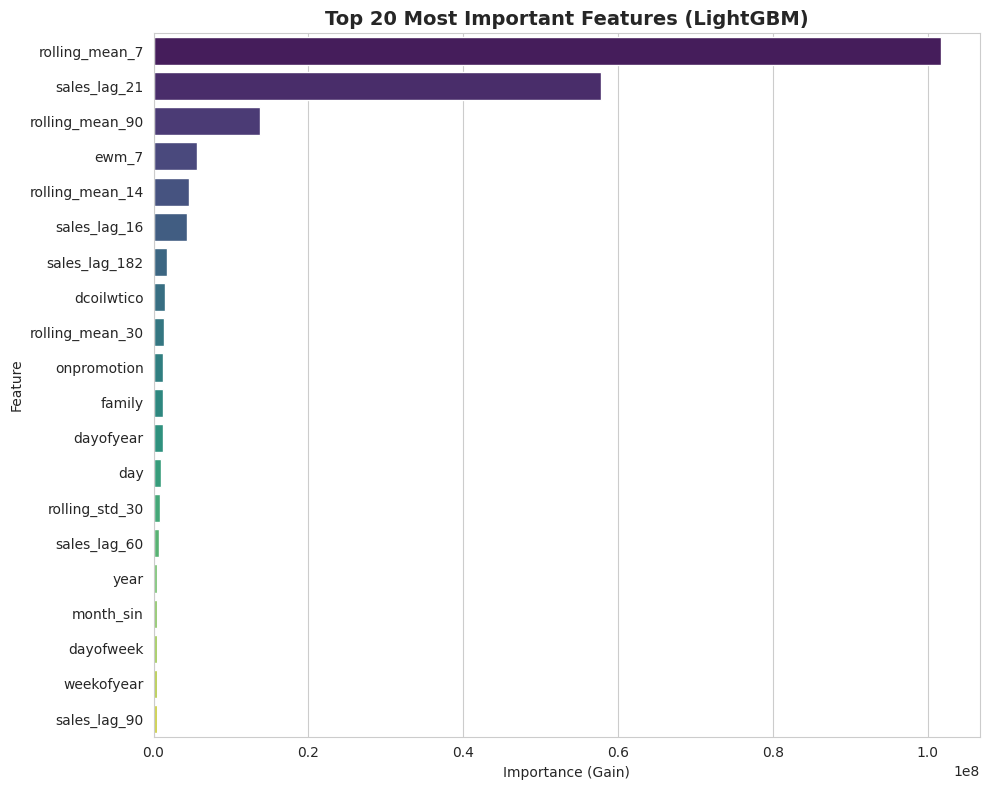


Top 10 Features:


,feature,importance
38,rolling_mean_7,1.016764e+08
32,sales_lag_21,5.784368e+07
44,rolling_mean_90,1.373184e+07
46,ewm_7,5.668225e+06
40,rolling_mean_14,4.526139e+06
31,sales_lag_16,4.387729e+06
36,sales_lag_182,1.801505e+06
7,dcoilwtico,1.504663e+06
42,rolling_mean_30,1.312587e+06
2,onpromotion,1.260835e+06


In [16]:
# Get feature importance from LightGBM
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgb_model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df.head(20), y='feature', x='importance', palette='viridis')
plt.title('Top 20 Most Important Features (LightGBM)', fontsize=14, fontweight='bold')
plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print('\nTop 10 Features:')
display(importance_df.head(10))

## 8️⃣ Generate Test Predictions

In [17]:
# Prepare test data
X_test = test_final[feature_cols].fillna(0)

# Get predictions from all models
print('Generating test predictions...')

lgb_test_pred = np.expm1(lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration))
lgb_test_pred = np.maximum(0, lgb_test_pred)

xgb_test = xgb.DMatrix(X_test)
xgb_test_pred = np.expm1(xgb_model.predict(xgb_test))
xgb_test_pred = np.maximum(0, xgb_test_pred)

cat_test_pred = np.expm1(cat_model.predict(X_test))
cat_test_pred = np.maximum(0, cat_test_pred)

# Ensemble predictions
ensemble_test_pred = (
    weights[0] * lgb_test_pred +
    weights[1] * xgb_test_pred +
    weights[2] * cat_test_pred
)

print('✅ Test predictions generated')

Generating test predictions...
✅ Test predictions generated


## 9️⃣ Create Submission File

In [18]:
# Create submission dataframe
submission = pd.DataFrame({
    'id': test_final['id'],
    'sales': ensemble_test_pred
})

# Save to CSV
submission.to_csv('submission.csv', index=False)

print('✅ Submission file created: submission.csv')
print(f'\nSubmission Statistics:')
print(submission['sales'].describe())
print(f'\nSample predictions:')
display(submission.head(10))

✅ Submission file created: submission.csv

Submission Statistics:
count    28512.000000
mean       427.831975
std       1181.739038
min          0.000000
25%          3.732515
50%         26.874283
75%        241.345954
max      14209.889393
Name: sales, dtype: float64

Sample predictions:


,id,sales
0,3000888,4.286972
1,3002670,3.974123
2,3004452,4.209705
3,3006234,4.484187
4,3008016,2.234400
5,3009798,4.082547
6,3011580,4.091069
7,3013362,4.362431
8,3015144,3.854504
9,3016926,4.546701
